# Recommended weekly exercise

The American Heart Association [recommends](https://www.heart.org/en/healthy-living/fitness/fitness-basics/aha-recs-for-physical-activity-in-adults) 150 minutes per week of moderate-intensity aerobic exercise or 75 minutes per week of vigorous aerobic exercise, or a combination of the two. Using Apple Health data, see how much walking and running you are doing.

To access the data on your iPhone, from the Health app go to Health Data -> [Portrait icon at top right] -> Export Health Data. Save `export.zip` to Files, which then can be uploaded to this applet from your iPhone browser.

In [1]:
apple_health_export_path = ''
apple_health_export_path__format = 'upload'

# a brisk walk is considered moderate-intensity aerobic exercise
brisk_walk_pace = 2.5

# jogging/running is considered vigorous
jogging_pace = 3

weeks = 4

In [2]:
import zipfile
from lxml import etree
from collections import Counter
import pandas as pd
import matplotlib.pyplot as plt
from datetime import timedelta
from IPython.display import HTML

if not apple_health_export_path:
    apple_health_export_path = '/Users/lhon/Downloads/export.zip'

In [3]:
# extract export.xml and parse xml
zf = zipfile.ZipFile(apple_health_export_path)
export_xml_path = [x.filename for x in zf.filelist if 'export.xml' in x.filename][0]
tree = etree.parse(zf.open(export_xml_path))
root = tree.getroot()

# identify iPhone sourceName descriptor based on frequency
sourceName = Counter(e.attrib['sourceName'] for e in root.xpath('//Record')).most_common()[0][0]

In [4]:
def get_time_in_seconds(t):
    return int(t[11:13])*3600 + int(t[14:16])*60 + int(t[17:19])

# extract data into dataframe
data = []
for elem in root.xpath('//Record[@type="HKQuantityTypeIdentifierDistanceWalkingRunning" and @sourceName="%s"]' % sourceName):
    start = get_time_in_seconds(elem.attrib['startDate'])
    end = get_time_in_seconds(elem.attrib['endDate'])
    seconds = end - start
    if seconds < 300: continue
    distance = float(elem.attrib['value'])
    date = elem.attrib['startDate'][:10]
    data.append([seconds/60, distance, distance/(seconds/3600), date])
df = pd.DataFrame(data, columns='minutes distance speed date'.split())

In [5]:
# https://stackoverflow.com/questions/29882573/pandas-slow-date-conversion
def date_lookup(s):
    dates = {date:pd.to_datetime(date) for date in s.unique()}
    return s.map(dates)
df['date'] = date_lookup(df['date'])
#df.head()

In [6]:
# assign activity labels based on speed
moderate = 'brisk walk'
vigorous = 'jogging/running'
labels = [moderate, vigorous]
df['activity'] = pd.cut(df.speed, [brisk_walk_pace, jogging_pace, 20], labels=labels)

# find date N weeks ago
end = df.iloc[-1].date
start = end - timedelta(days=weeks*7-1)

# calculate activity time per week for time range
summary = (df
 .query('date >= @start and minutes >= 9 and activity.isin(@labels)')
 .groupby('activity').minutes.sum().div(weeks)
)

HTML('Active minutes per week:<br /><span style="font-size: 36px">%d</span>' % (summary.loc[moderate] + summary.loc[vigorous]*2))

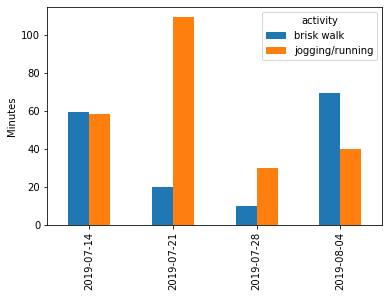

In [7]:
temp = (df
 .set_index('date')
 .query('date > @start and minutes >= 9')
 .groupby([pd.Grouper(freq="W"), 'activity'])['minutes'].sum()
 .unstack('activity')
)
temp.index = temp.index.format()
temp.plot.bar(stacked=False)
plt.ylabel('Minutes');